<h1 style="color:yellow;">Concurrent Data - Machine Learning</h1>

# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import time
import sys
sys.path.append(os.path.abspath(".."))

from utils import print_evaluation_metrics, print_memory_usage, clean_database, \
    analyze_correlations, perform_voting_feature_selection, \
    log_metrics, plot_individual_metrics
from preprocess import preprocessing

pd.set_option('display.max_columns', None)
preprocessing_dir = os.path.join('figures','preprocessing')
results_dir = os.path.join('figures', 'results')
evaluation_dir = os.path.join('figures','evaluation charts')
db_path = os.path.join('..', 'data', 'datasets', '5G NIDD', 'Combined.csv')

# Data cleaning and splitting

[Preprocessing] Dropping artifact columns: ['Unnamed: 0']
Original shape: (1215890, 51)
Shape after removing duplicates: (1215869, 51)

[Dataset Info] Attack Type Distribution (Counts):
Attack Type
Benign            477716
UDPFlood          457340
HTTPFlood         140812
SlowrateDoS        73124
TCPConnectScan     20052
SYNScan            20043
UDPScan            15906
SYNFlood            9721
ICMPFlood           1155
Name: count, dtype: int64
[Preprocessing] Final feature set (40): ['Dur', 'Mean', 'Sum', 'Min', 'Max', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset', 'sMeanPktSz', 'dMeanPktSz', 'Load', 'SrcLoad', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'pLoss', 'SrcGap', 'DstGap', 'Rate', 'SrcRate', 'DstRate', 'State', 'SrcWin', 'DstWin', 'TcpRtt', 'SynAck', 'AckDat']

[Verification] Class distribution (normalized) across splits:
                Original     Train       Val      Test
Attac

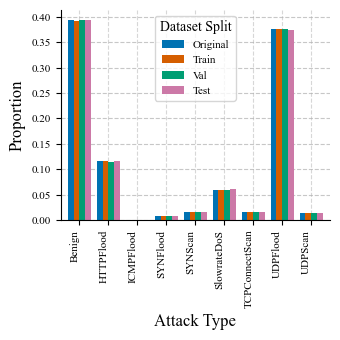

[Memory] Before GC: 1526.19 MB
[Memory] After GC: 1312.20 MB
[Preprocessing] Applying PowerTransformer (Yeo-Johnson) to fix skewness and standardize data...
[Visualization] Plotting top 3 skewed features before transformation: ['DstGap', 'SrcGap', 'DstRate']


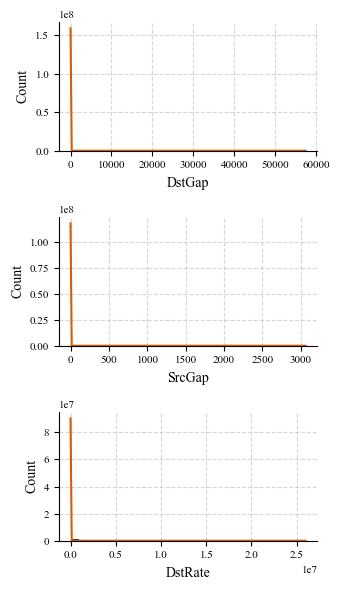

[Visualization] Plotting top 3 skewed features after transformation


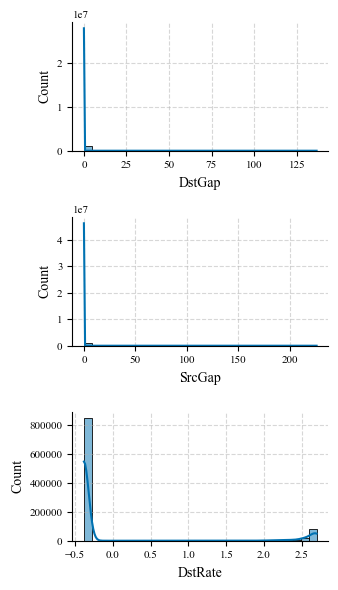

<class 'pandas.core.frame.DataFrame'>
Index: 972695 entries, 285273 to 583254
Data columns (total 40 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dur         972695 non-null  float32
 1   Mean        972695 non-null  float32
 2   Sum         972695 non-null  float32
 3   Min         972695 non-null  float32
 4   Max         972695 non-null  float32
 5   Proto       972695 non-null  float32
 6   sTos        972695 non-null  float32
 7   dTos        972695 non-null  float32
 8   sDSb        972695 non-null  float32
 9   dDSb        972695 non-null  float32
 10  sTtl        972695 non-null  float32
 11  dTtl        972695 non-null  float32
 12  Cause       972695 non-null  float32
 13  TotPkts     972695 non-null  float32
 14  SrcPkts     972695 non-null  float32
 15  DstPkts     972695 non-null  float32
 16  TotBytes    972695 non-null  float32
 17  SrcBytes    972695 non-null  float32
 18  DstBytes    972695 non-null  float32
 19  Of

In [2]:
X_train, X_val, X_test, y_train, y_val, y_test, output_encoder = clean_database(db_path, preprocessing_dir, do_scale=False, fix_skewness=True)
# Force garbage collection to clear the large raw dataframe from memory immediately
gc.collect()
print_memory_usage("Notebook - After clean_database")

# Feature Selection

## Correlations

### Analyze correlation between featrues

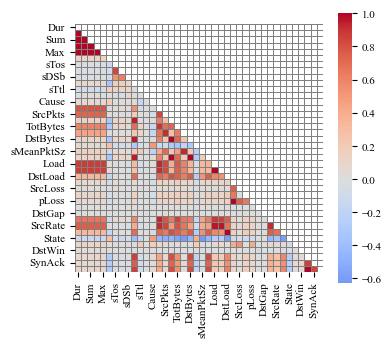


[Analysis] Features with correlation > 0.95:
  - Mean is correlated with ['Dur']
  - Sum is correlated with ['Dur', 'Mean']
  - Min is correlated with ['Dur', 'Mean', 'Sum']
  - Max is correlated with ['Dur', 'Mean', 'Sum', 'Min']
  - DstBytes is correlated with ['dDSb', 'DstPkts']
  - dMeanPktSz is correlated with ['dDSb', 'DstPkts', 'DstBytes']
  - SrcLoad is correlated with ['Load']
  - pLoss is correlated with ['Loss']
  - SrcRate is correlated with ['Load', 'SrcLoad']
  - DstRate is correlated with ['DstLoad']
  - AckDat is correlated with ['TcpRtt']


In [3]:
high_corr_features = analyze_correlations(X_train, threshold=0.95)

### Drop correlated featuers

In [4]:
# Use inplace=True to avoid creating a copy of the dataframe in memory
X_train.drop(columns=high_corr_features, inplace=True)
X_val.drop(columns=high_corr_features, inplace=True)
X_test.drop(columns=high_corr_features, inplace=True)
print(f"Dropped {len(high_corr_features)} correlated features.")

gc.collect()
print_memory_usage("Notebook - After Dropping Correlated Features")

Dropped 11 correlated features.
[Memory] Notebook - After Dropping Correlated Features: 1587.05 MB


In [5]:
# Print the number of remaining features
print(f"Remaining features count: {X_train.shape[1]}")

# Print the list of remaining feature names
print("Remaining features list:")
print(X_train.columns.tolist())

Remaining features count: 29
Remaining features list:
['Dur', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'SrcGap', 'DstGap', 'Rate', 'State', 'SrcWin', 'DstWin', 'TcpRtt', 'SynAck']


# Arguments

In [6]:
version = 'ML'
sampling_method = 'smote'
plot_distributions = True
model_results= []

<h1 style="color:red;">Compare the results of all methods</h1>


[Comparison] Using full training data (972695 samples) for feature selection.

Comparing Feature Selection Methods

--- Filter Method: pearson ---

[Filter] Starting PEARSON Feature Selection to select top 15 features...
[Filter] Completed in 0.06 seconds.
[Filter] Selected Features: ['Dur', 'Proto', 'dDSb', 'sTtl', 'Cause', 'DstPkts', 'TotBytes', 'Offset', 'sMeanPktSz', 'DstLoad', 'Loss', 'State', 'SrcWin', 'TcpRtt', 'SynAck']
   -> Validation Accuracy: 0.9792

--- Filter Method: anova ---

[Filter] Starting ANOVA Feature Selection to select top 15 features...
[Filter] Completed in 0.12 seconds.
[Filter] Selected Features: ['Dur', 'Proto', 'dDSb', 'sTtl', 'TotPkts', 'DstPkts', 'TotBytes', 'Offset', 'Load', 'DstLoad', 'Rate', 'State', 'SrcWin', 'TcpRtt', 'SynAck']
   -> Validation Accuracy: 0.9791

--- Filter Method: chi2 ---

[Filter] Starting CHI2 Feature Selection to select top 15 features...
[Filter] Completed in 0.17 seconds.
[Filter] Selected Features: ['Dur', 'dDSb', 'TotPkts',

/opt/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


[Embedded] Completed in 30.45 seconds.
[Embedded] Selected Features: ['Dur', 'Proto', 'sDSb', 'dDSb', 'sTtl', 'Cause', 'TotBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'Rate', 'State', 'SrcWin', 'TcpRtt']
   -> Validation Accuracy: 0.9791

--- Embedded Method: ridge ---

[Embedded] Starting RIDGE Feature Selection to select top 15 features...


/opt/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


[Embedded] Completed in 55.50 seconds.
[Embedded] Selected Features: ['Proto', 'sDSb', 'dDSb', 'sTtl', 'Cause', 'TotPkts', 'SrcPkts', 'TotBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'State', 'SrcWin', 'TcpRtt']
   -> Validation Accuracy: 0.9791

--- Embedded Method: elastic_net ---

[Embedded] Starting ELASTIC_NET Feature Selection to select top 15 features...


/opt/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


[Embedded] Completed in 31.09 seconds.
[Embedded] Selected Features: ['Dur', 'Proto', 'sDSb', 'dDSb', 'sTtl', 'Cause', 'TotBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'Rate', 'State', 'SrcWin', 'TcpRtt']
   -> Validation Accuracy: 0.9791

--- Embedded Method: rf ---

[Embedded] Starting RF Feature Selection to select top 15 features...
[Embedded] Completed in 7.79 seconds.
[Embedded] Selected Features: ['Dur', 'Proto', 'dDSb', 'sTtl', 'Cause', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'Rate', 'State', 'SrcWin', 'TcpRtt', 'SynAck']
   -> Validation Accuracy: 0.9791

--- Embedded Method: gradient_boosting ---

[Embedded] Starting GRADIENT_BOOSTING Feature Selection to select top 15 features...
[Embedded] Completed in 885.48 seconds.
[Embedded] Selected Features: ['Dur', 'Proto', 'sTtl', 'Cause', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'State', 'SrcWin', 'DstWin', 'TcpRtt']
   -> Validation Accuracy: 0.9791

Summary of Validation 

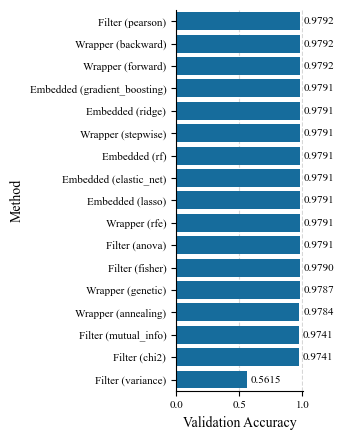


[Debugging] Feature Selection Verification

Rank 1: Filter (pearson) (Acc: 0.9792)
  Features: ['Dur', 'Proto', 'dDSb', 'sTtl', 'Cause', 'DstPkts', 'TotBytes', 'Offset', 'sMeanPktSz', 'DstLoad', 'Loss', 'State', 'SrcWin', 'TcpRtt', 'SynAck']

Rank 2: Wrapper (backward) (Acc: 0.9792)
  Features: ['sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'TotBytes', 'Offset', 'sMeanPktSz', 'Loss', 'SrcLoss', 'Rate', 'State', 'SrcWin', 'DstWin', 'TcpRtt']

Rank 3: Wrapper (forward) (Acc: 0.9792)
  Features: ['Proto', 'sDSb', 'dDSb', 'sTtl', 'Cause', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'SrcGap', 'Rate', 'State', 'SrcWin', 'TcpRtt']

Rank 4: Embedded (gradient_boosting) (Acc: 0.9791)
  Features: ['Dur', 'Proto', 'sTtl', 'Cause', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'State', 'SrcWin', 'DstWin', 'TcpRtt']

Rank 5: Embedded (ridge) (Acc: 0.9791)
  Features: ['Proto', 'sDSb', 'dDSb', 'sTtl', 'Cause', 'TotPkts', 'SrcPkts', 'TotBytes', 'Offset', 

In [7]:
selected_features, comparison_results = perform_voting_feature_selection(
    X_train, y_train, X_val, y_val, 
    n_features=15, 
    sample_size=None,  # <--- Performance Fix
    top_k=3,
    file_path=preprocessing_dir,
    version=version
)
gc.collect()
print_memory_usage("Notebook - After Feature Selection")

## Filter the dataframes to include only selected columns

In [8]:
# Overwrite your dataframes to keep ONLY the selected columns
X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

# Preprocessing

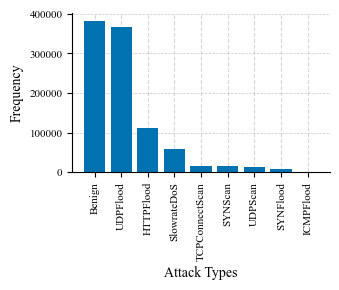

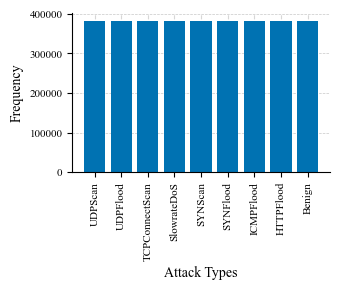


[Preprocessing] Final dataset sizes (after smote):
  - Training samples: 3438171
  - Validation samples: 121587
  - Test samples: 121587
[Memory] Notebook - Ready for Training: 1412.05 MB


In [9]:
X_train_processed, X_val_processed, X_test_processed, y_train_processed, y_val_processed, y_test_processed = preprocessing(X_train, X_val, X_test, y_train, y_val, y_test, output_encoder, preprocessing_dir, version, sampling_method, plot_distributions)
print_memory_usage("Notebook - Ready for Training")

In [10]:
# 1. Define the directory to save the processed data
# You can adjust the path name as needed
save_dir = os.path.join('..', 'data frames', 'ML','15 Features')

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory: {save_dir}")

print(f"Saving data to: {os.path.abspath(save_dir)}")

# 2. Save the feature matrices (X)
# These are already numpy arrays (float32) from your preprocessing function
np.save(os.path.join(save_dir, 'X_train_processed.npy'), X_train_processed)
np.save(os.path.join(save_dir, 'X_val_scaled.npy'), X_val_processed)
np.save(os.path.join(save_dir, 'X_test_scaled.npy'), X_test_processed)

# 3. Save the target vectors (y)
np.save(os.path.join(save_dir, 'y_resampled.npy'), y_train_processed)
np.save(os.path.join(save_dir, 'y_val.npy'), y_val_processed)
np.save(os.path.join(save_dir, 'y_test.npy'), y_test_processed)

# 4. Save the label encoder classes
# This is crucial if you want to map predictions back to original names (e.g., 'Benign', 'DDoS') later
np.save(os.path.join(save_dir, 'label_classes.npy'), output_encoder.classes_)

print("All datasets saved successfully.")

Created directory: ../data frames/ML/15 Features
Saving data to: /Users/hemaali/Desktop/Master Degree Project/data frames/ML/15 Features
All datasets saved successfully.


# Machine Learning

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB


## Logistic Regression

In [12]:
linear_model = LogisticRegression(solver='saga', max_iter=1000, n_jobs=-1, random_state=42)

start_time = time.time()
linear_model.fit(X_train_processed, y_train_processed)
training_time = time.time() - start_time

start_time = time.time()
y_pred_lr = linear_model.predict(X_val_processed)
prediction_time = time.time() - start_time


/opt/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


Logistic Regression Evaluation:
Accuracy: 0.96197784
Precision: 0.96218303
Recall: 0.96197784
F1 Score: 0.96199302
Training Time: 52.7517 seconds
Prediction Time: 0.0077 seconds
latency per sample: 0.00000006 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.96428496 0.94964555 0.95690927     47821
     HTTPFlood  0.98095854 0.97416869 0.97755182     14014
     ICMPFlood  0.97600000 1.00000000 0.98785425       122
      SYNFlood  0.98169557 0.99901961 0.99028183      1020
       SYNScan  0.99156328 0.99501992 0.99328859      2008
   SlowrateDoS  0.91545265 0.97560299 0.94457120      7214
TCPConnectScan  0.96844181 0.99746064 0.98273705      1969
      UDPFlood  0.95883299 0.96392147 0.96137049     45789
       UDPScan  0.98302001 0.99447853 0.98871607      1630

      accuracy                      0.96197784    121587
     macro avg  0.96891665 0.98325749 0.97592006    121587
  weighted avg  0.96218303 0.96197784 0.96199302    1

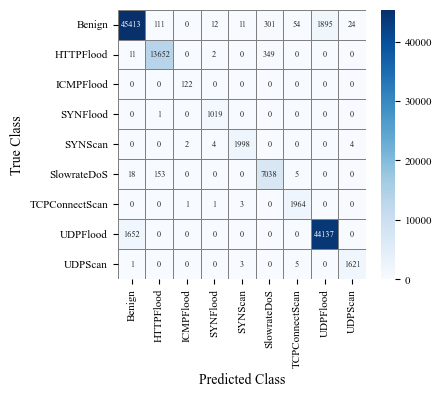

In [13]:
# arguments for evaluation function
results_file_name = 'logistic_regression_results.txt'
cm_title = 'Logistic Regression Confusion Matrix'

print("Logistic Regression Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_processed, y_pred_lr, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'logistic_regression', accuracy, precision, recall, f1, training_time, prediction_time)

## Random Forest

In [14]:
rnd_forest = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs = -1)
start_time = time.time()
rnd_forest.fit(X_train_processed, y_train_processed)
training_time = time.time() - start_time

start_time = time.time()
y_pred_rf = rnd_forest.predict(X_val_processed)
prediction_time = time.time() - start_time

# arguments for evaluation function
model_type = 'random_forest'
results_file_name = 'random_forest_results.txt'
cm_title = 'Random Forest Confusion Matrix'

Evaluation:
Accuracy: 0.97915073
Precision: 0.97915085
Recall: 0.97915073
F1 Score: 0.97915070
Training Time: 20.9921 seconds
Prediction Time: 0.0993 seconds
latency per sample: 0.00000082 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.97449791 0.97406997 0.97428389     47821
     HTTPFlood  0.99743224 0.99785928 0.99764572     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  1.00000000 1.00000000 1.00000000      1020
       SYNScan  0.99850374 0.99701195 0.99775729      2008
   SlowrateDoS  0.99583854 0.99514832 0.99549331      7214
TCPConnectScan  0.99898322 0.99796851 0.99847561      1969
      UDPFlood  0.97297474 0.97339972 0.97318719     45789
       UDPScan  0.99571865 0.99877301 0.99724349      1630

      accuracy                      0.97915073    121587
     macro avg  0.99266100 0.99269231 0.99267628    121587
  weighted avg  0.97915085 0.97915073 0.97915070    121587



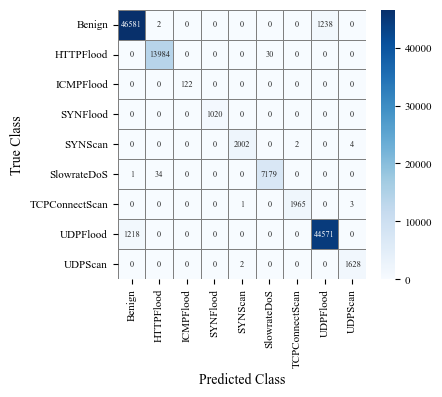

In [15]:
# arguments for evaluation function
results_file_name = 'random_forest_results.txt'
cm_title = 'Random Forest Confusion Matrix'

print("Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_processed, y_pred_rf, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'random_forest', accuracy, precision, recall, f1, training_time, prediction_time)

## XGBoost

In [16]:
# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(output_encoder.classes_), eval_metric='mlogloss')

# Train the model
start_time = time.time()
xgb_model.fit(X_train_processed, y_train_processed)
training_time = time.time() - start_time

# Make predictions
start_time = time.time()
y_pred_xgb = xgb_model.predict(X_val_processed)
prediction_time = time.time() - start_time

XGBoost Evaluation:
Accuracy: 0.98197998
Precision: 0.98249168
Recall: 0.98197998
F1 Score: 0.98198082
Training Time: 15.1771 seconds
Prediction Time: 0.1046 seconds
latency per sample: 0.00000086 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.99574819 0.95987119 0.97748059     47821
     HTTPFlood  0.99764605 0.99800200 0.99782399     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  0.99706745 1.00000000 0.99853157      1020
       SYNScan  0.99900000 0.99501992 0.99700599      2008
   SlowrateDoS  0.99611597 0.99542556 0.99577064      7214
TCPConnectScan  0.99847561 0.99796851 0.99822200      1969
      UDPFlood  0.95963040 0.99571950 0.97734191     45789
       UDPScan  0.99511301 0.99938650 0.99724518      1630

      accuracy                      0.98197998    121587
     macro avg  0.99319963 0.99348813 0.99326910    121587
  weighted avg  0.98249168 0.98197998 0.98198082    121587



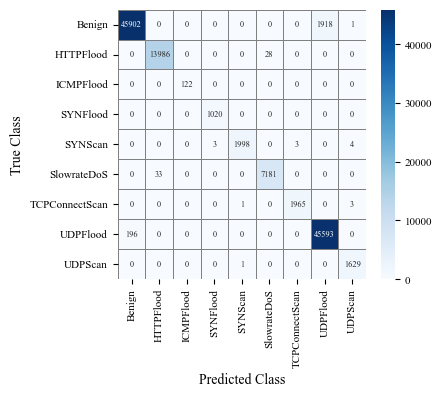

In [17]:
# arguments for evaluation function
results_file_name = 'xgboost_results.txt'
cm_title = 'XGBoost Confusion Matrix'

print("XGBoost Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_processed, y_pred_xgb, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'xgboost', accuracy, precision, recall, f1, training_time, prediction_time)

## Naive Bayes

In [18]:
# Create a Naive Bayes classifier
nb_model = GaussianNB()

# Train the model
start_time = time.time()
nb_model.fit(X_train_processed, y_train_processed)
training_time = time.time() - start_time

# Make predictions
start_time = time.time()
y_pred_nb = nb_model.predict(X_val_processed)
prediction_time = time.time() - start_time

Naive Bayes Evaluation:
Accuracy: 0.68406162
Precision: 0.82157299
Recall: 0.68406162
F1 Score: 0.64756653
Training Time: 0.2346 seconds
Prediction Time: 0.0163 seconds
latency per sample: 0.00000013 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.99290389 0.26333619 0.41627000     47821
     HTTPFlood  0.95749497 0.81497074 0.88050266     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  1.00000000 0.98823529 0.99408284      1020
       SYNScan  1.00000000 0.99352590 0.99675244      2008
   SlowrateDoS  0.71975481 0.92777932 0.81063405      7214
TCPConnectScan  1.00000000 0.98730320 0.99361104      1969
      UDPFlood  0.61982565 1.00000000 0.76529922     45789
       UDPScan  0.18410808 0.98650307 0.31030490      1630

      accuracy                      0.68406162    121587
     macro avg  0.83045416 0.88462819 0.79638413    121587
  weighted avg  0.82157299 0.68406162 0.64756653    121587



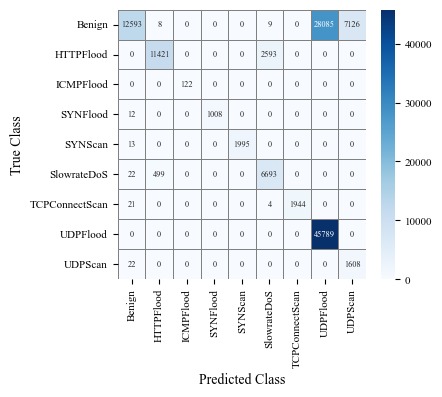

In [19]:
# arguments for evaluation function
results_file_name = 'naive_bayes_results.txt'
cm_title = 'Naive Bayes Confusion Matrix'

print("Naive Bayes Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_processed, y_pred_nb, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'naive_bayes', accuracy, precision, recall, f1, training_time, prediction_time)

## SVM

In [20]:
LSVC = LinearSVC(dual=False, random_state=42)

### Use One-vs-Rest classifier

In [21]:
ovr_classifier = OneVsRestClassifier(estimator=LSVC, n_jobs=-1)
start_time = time.time()
ovr_classifier.fit(X_train_processed, y_train_processed)
training_time = time.time() - start_time

start_time = time.time()
y_pred_svm = ovr_classifier.predict(X_val_processed)
prediction_time = time.time() - start_time

SVM Evaluation:
Accuracy: 0.95392600
Precision: 0.95537936
Recall: 0.95392600
F1 Score: 0.95419777
Training Time: 32.5520 seconds
Prediction Time: 0.0182 seconds
latency per sample: 0.00000015 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.96355598 0.93879258 0.95101310     47821
     HTTPFlood  0.97822409 0.94883688 0.96330641     14014
     ICMPFlood  0.97600000 1.00000000 0.98785425       122
      SYNFlood  0.98169557 0.99901961 0.99028183      1020
       SYNScan  0.98944724 0.98057769 0.98499250      2008
   SlowrateDoS  0.84715840 0.97116717 0.90493413      7214
TCPConnectScan  0.83753741 0.99492128 0.90947075      1969
      UDPFlood  0.95970409 0.96328813 0.96149277     45789
       UDPScan  0.95892857 0.98834356 0.97341390      1630

      accuracy                      0.95392600    121587
     macro avg  0.94358348 0.97610521 0.95852885    121587
  weighted avg  0.95537936 0.95392600 0.95419777    121587



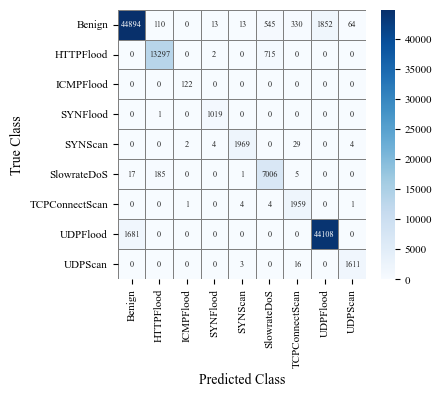

In [22]:
# arguments for evaluation function
results_file_name = 'svm_results.txt'
cm_title = 'Support Vector Machine Confusion Matrix'

print("SVM Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_processed, y_pred_svm, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'svm', accuracy, precision, recall, f1, training_time, prediction_time)

# Bar charts

Saved ML_comparison_accuracy.pdf


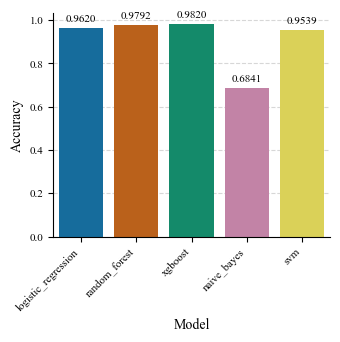

Saved ML_comparison_precision.pdf


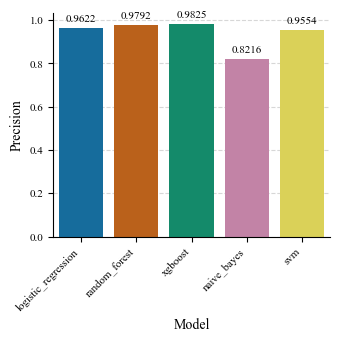

Saved ML_comparison_recall.pdf


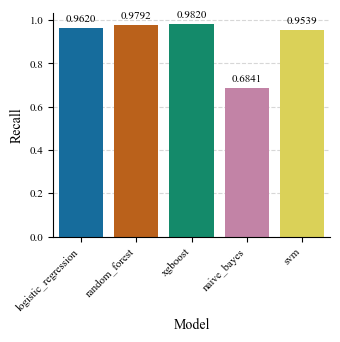

Saved ML_comparison_f1-score.pdf


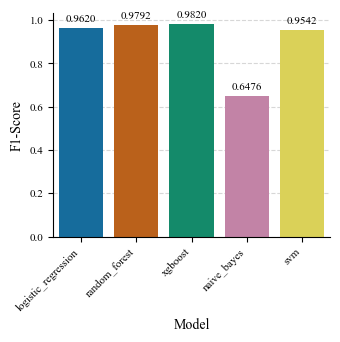

Saved ML_comparison_training_time_s.pdf


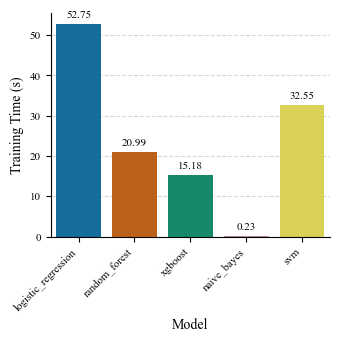

Saved ML_comparison_prediction_time_s.pdf


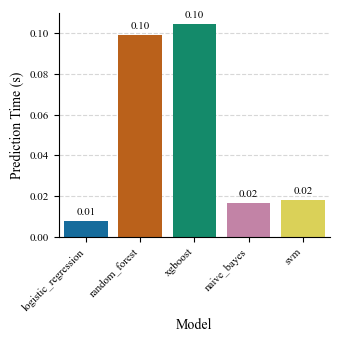

In [23]:
plot_individual_metrics(model_results, evaluation_dir, version)